## In this notebook we'll test implementation of the foundation model

In [1]:
import torch
import numpy as np
import glob
import os
from os.path import join as opj
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tqdm
from dataset import TimeSeriesDataset
from models import MaskedAutoencoder, MaskedAutoencoderLightning
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger


/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42

## 0. Data Loading

In [3]:
# define the data path
data_path = "/srv/nfs-data/janeway/UDGSL_Dataset/HCP"

# choose the ica dimensionality
d_in = 25
ica = f"ica{d_in}"

#get the list of subjects
file_list = glob.glob(opj(data_path,ica,"*.npy"))

# split the data into training and testing
train_list, test_list = train_test_split(file_list, test_size=0.2, random_state=random_seed)

In [4]:
# create the datasets

train_dataset = TimeSeriesDataset(train_list)
test_dataset = TimeSeriesDataset(test_list)

In [5]:
## get some data
x , y = next(iter(train_dataset))

#check the shape
print("x shape: ", x.shape)
print("y label:", y)


x shape:  torch.Size([4800, 25])
y label: 1


Text(0, 0.5, 'Intensity')

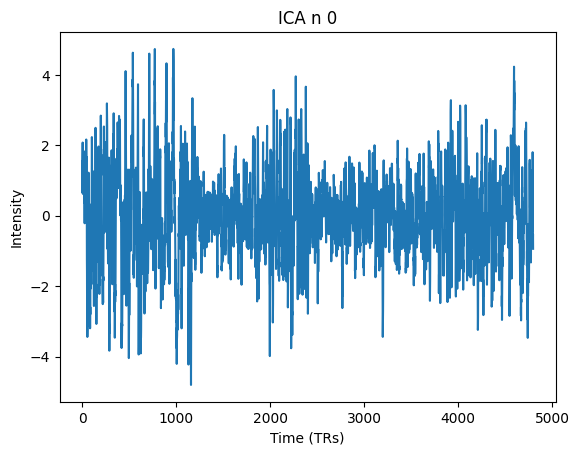

In [6]:
## visualize the data
sample_dim = 0

plt.plot(x[:,sample_dim])
plt.title(f"ICA n {sample_dim}")
plt.xlabel("Time (TRs)")
plt.ylabel("Intensity")

In [7]:
## define dataloaders

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
## check shapes of the dataloaders
x, y = next(iter(train_loader))

print("x shape: ", x.shape, "Expected: (BS, seq_len, d_in): ", (batch_size, "seq_len", d_in))
print("y shape: ", y.shape, "Expected: (BS,): ", (batch_size,))


x shape:  torch.Size([4, 4800, 25]) Expected: (BS, seq_len, d_in):  (4, 'seq_len', 25)
y shape:  torch.Size([4]) Expected: (BS,):  (4,)


## 1. Model Patch and Masking

In [9]:
## define patch size 
patch_size = 20

# create the model

model = MaskedAutoencoderLightning(patch_size=patch_size, d_in=d_in)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
## check patching
x_patches = model.patchify(x)
print(f'x_patches shape: {x_patches.shape}', f'Expected: (BS, n_windows, patch_size, d_in): {(batch_size, "n_windows", patch_size, d_in)}')
print("n windows should be equal to the sequence length divided by the patch size: ", x.shape[1]//patch_size)

x_patches shape: torch.Size([4, 240, 20, 25]) Expected: (BS, n_windows, patch_size, d_in): (4, 'n_windows', 20, 25)
n windows should be equal to the sequence length divided by the patch size:  240


In [11]:
## check unpatching
x_reconstructed = model.depatchify(x_patches)

print(f'x_reconstructed shape: {x_reconstructed.shape}', f'Expected: (BS, seq_len, d_in): {(batch_size, x.shape[1], d_in)}')

x_reconstructed shape: torch.Size([4, 4800, 25]) Expected: (BS, seq_len, d_in): (4, 4800, 25)


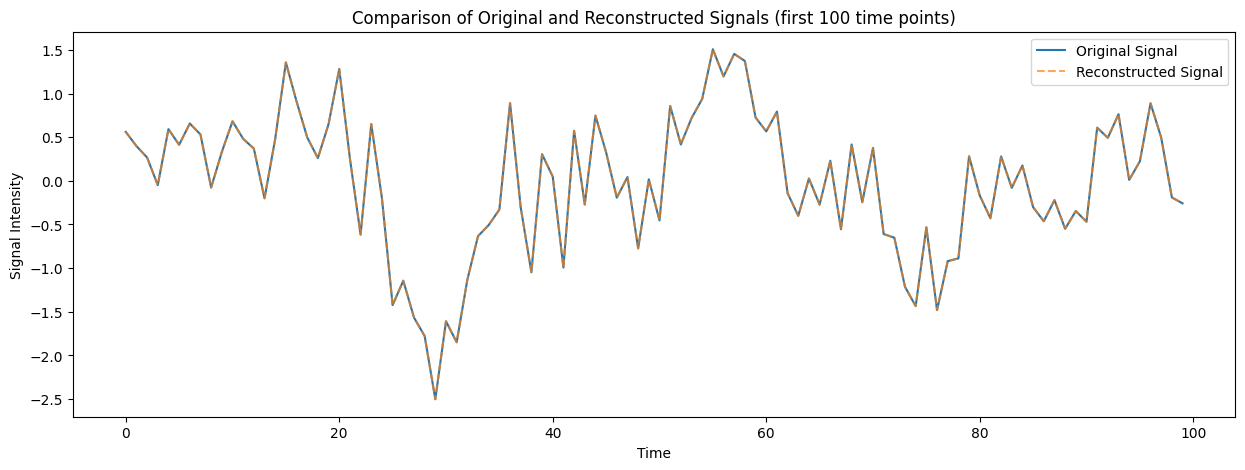

In [12]:
## visualization 
# Select a sample and dimension
sample_idx = 0
dim_idx = 0

# Original signal (trimmed)
original_signal = x[sample_idx, :100, dim_idx]

# Reconstructed signal
reconstructed_signal = x_reconstructed[sample_idx, :100, dim_idx]

# Plot both signals
plt.figure(figsize=(15, 5))
plt.plot(original_signal.numpy(), label='Original Signal')
plt.plot(reconstructed_signal.numpy(), linestyle='--', label='Reconstructed Signal',alpha=0.7)
plt.title('Comparison of Original and Reconstructed Signals (first 100 time points)')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()


In [13]:
# Calculate effective sequence length
n_patches = x_patches.shape[1]
effective_seq_len = n_patches * patch_size

# Trim the original data
data_trimmed = x[:, :effective_seq_len, :]

# Check if reconstructed data matches the trimmed original data
is_close = torch.allclose(x_reconstructed, data_trimmed, atol=1e-6)
print(f'Does reconstructed data match original data? {is_close}')


Does reconstructed data match original data? True


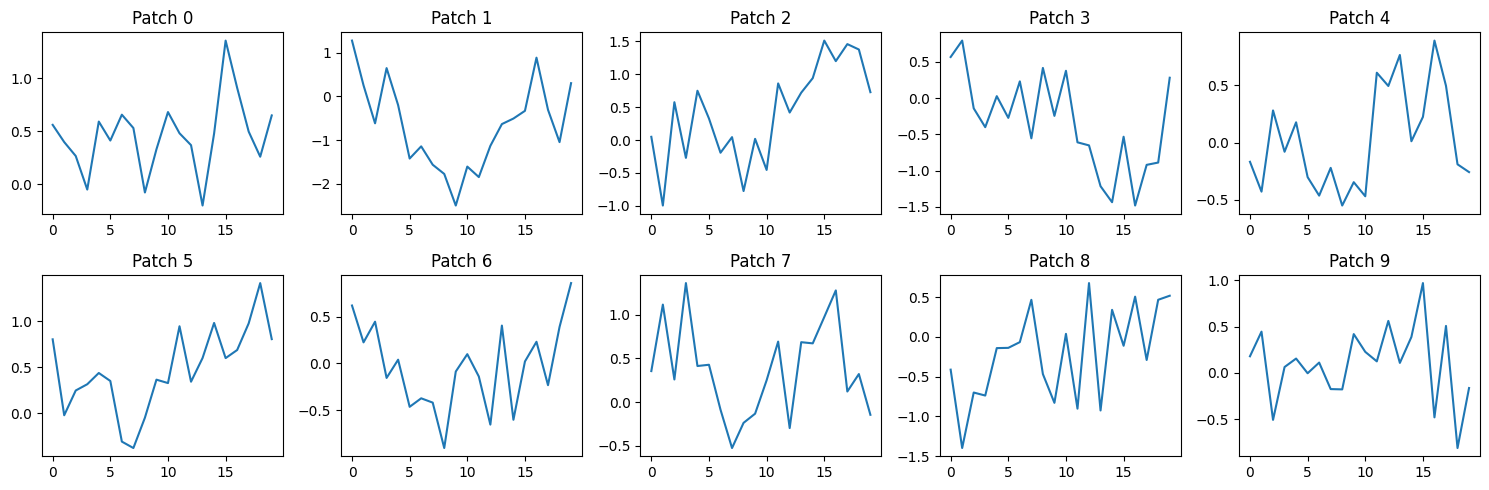

In [14]:
sample_idx = 0
dim_idx = 0

# Extract patches
patches = x_patches[sample_idx, :, :, dim_idx]  # Shape: (n_patches, patch_size)

# Plot the first few patches
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    if i < patches.shape[0]:
        ax.plot(patches[i].numpy())
        ax.set_title(f'Patch {i}')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()


In [47]:
MR = 0.75
x_masked, mask = model.mask_patches(x_patches, mask_ratio=MR)
print(f'x_masked shape: {x_masked.shape}')
print(f'mask shape: {mask.shape}')


x_masked shape: torch.Size([4, 240, 20, 25])
mask shape: torch.Size([4, 240, 25])


In [48]:
# check mask ratio
print(f'Mask ratio: {mask.sum() / mask.numel()}', f'Expected: {MR}')

Mask ratio: 0.7458333373069763 Expected: 0.75


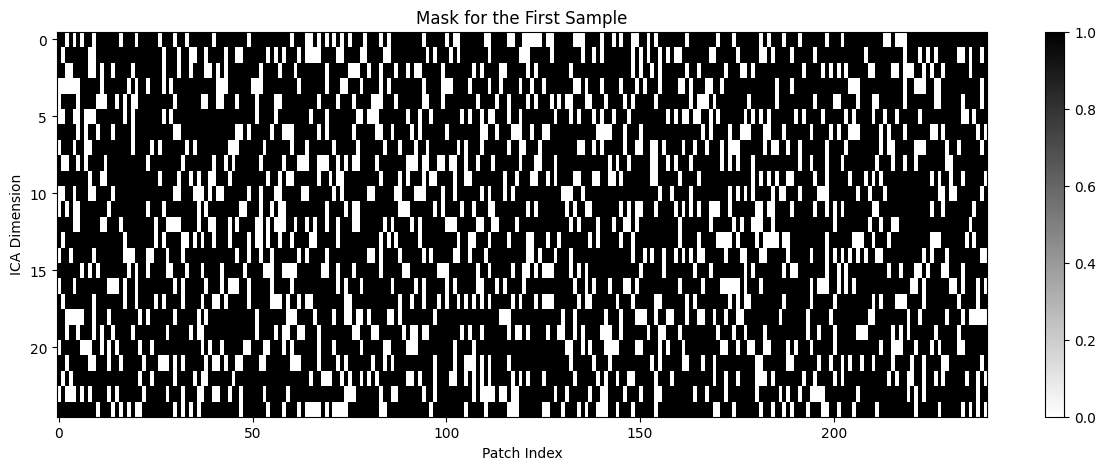

In [49]:
## plot the mask as a heatmap
plt.figure(figsize=(15, 5))
plt.imshow(mask[0].T, cmap='binary', aspect='auto')
plt.xlabel('Patch Index')
plt.ylabel('ICA Dimension')
plt.title('Mask for the First Sample')
plt.colorbar()

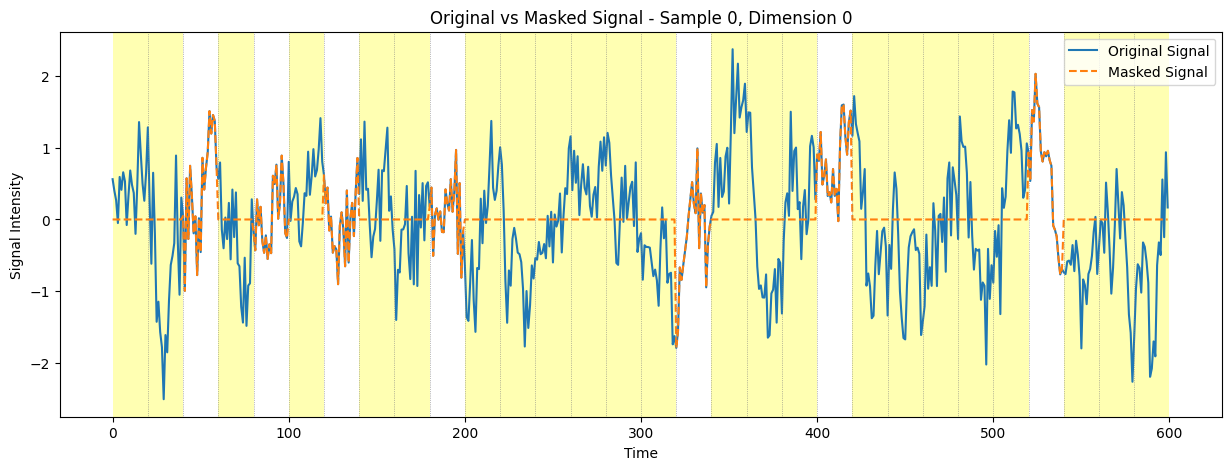

In [50]:
how_many_patches = 30

# Reconstruct original signal
original_patches = x_patches[sample_idx, :how_many_patches, :, dim_idx]  # Shape: (n_patches, patch_size)
original_signal = original_patches.reshape(-1)

# Reconstruct masked signal
masked_patches = x_masked[sample_idx, :how_many_patches, :, dim_idx]
masked_signal = masked_patches.reshape(-1)

# Get mask for the sample and dimension
mask_sample = mask[sample_idx, :how_many_patches, dim_idx]  # Shape: (n_patches,)

# Plot the signals
plt.figure(figsize=(15, 5))
plt.plot(original_signal.numpy(), label='Original Signal')
plt.plot(masked_signal.numpy(), label='Masked Signal', linestyle='--')

# Add vertical dotted lines at patch boundaries
for i in range(1, how_many_patches):
    plt.axvline(x=i * patch_size, color='gray', linestyle=':', linewidth=0.5)

# Apply background color to masked patches
for i, m in enumerate(mask_sample):
    if m.item() == 1.0:
        start = i * patch_size
        end = (i + 1) * patch_size
        plt.axvspan(start, end, facecolor='yellow', alpha=0.3)

plt.title(f'Original vs Masked Signal - Sample {sample_idx}, Dimension {dim_idx}')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()




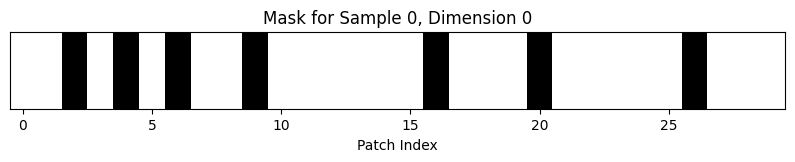

In [54]:
## corresponding mask

mask_sample = mask[sample_idx, :how_many_patches, dim_idx]  # Shape: (n_patches,)
plt.figure(figsize=(10, 1))
plt.imshow(mask_sample.unsqueeze(0), cmap='gray', aspect='auto')
plt.title(f'Mask for Sample {sample_idx}, Dimension {dim_idx}')
plt.xlabel('Patch Index')
plt.yticks([])
plt.show()